In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.append('./../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from matplotlib import style
#rc('animation', html='html5')

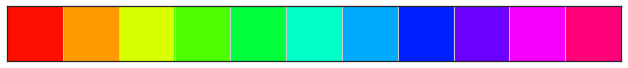

In [3]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.5, s=1.0))
#current_palette = sns.color_palette(sns.hls_palette(21+1, l=.5, s=1.0))

sns.palplot(current_palette)


In [23]:
from utility.dataset import _process_Synthetic
from models_utility.construct_models import _combine_models
from utility.eval_metric import _measure_metric, accuracy, compute_bic
#torch.set_default_tensor_type(torch.FloatTensor)


file_path = './dataset/synthetic/'
file_name = 'Q6_Fs200'
data_file_path = file_path + file_name


##############################################################################
# load dataset
##############################################################################
random_seed = 1000
num_exp = 1


###############################################
###############################################

exp_setting = {}
exp_setting['device'] = False

exp_setting['num_rep_exp'] = num_exp
exp_setting['data'] = file_name
exp_setting['full_length'] = 100

exp_setting['input_dim'] = 1
exp_setting['Num_HiddenState'] = 8
exp_setting['Num_Q'] = 4



x_train, y_train, z_train, x_test,y_test,z_test, true_freq , true_weight , true_noise_level ,true_num_state = _process_Synthetic(data_file_path,exp_setting)

exp_setting['input_length'] = x_train.shape[1]
z_test -= 1
z_train -= 1


In [26]:
###############################################################################################
# Model Setting
###############################################################################################

HMMGP_setting = {}
HMMGP_setting['emission'] = 'gpsm' #
HMMGP_setting['train'] = 'SVI' #


HMMGP_setting['Num_Q'] = exp_setting['Num_Q']
HMMGP_setting['lr_A'] = 0.05
HMMGP_setting['lr_pi'] = 0.05
HMMGP_setting['lr_hyp'] = 0.005


HMMGP_setting['Len_Full'] = exp_setting['full_length']
if HMMGP_setting['train'] == 'VBEM':
    HMMGP_setting['Len_Batch'] = HMMGP_setting['Len_Full']
    HMMGP_setting['Num_Batch'] = 1
else:
    HMMGP_setting['Len_Batch'] = 10
    HMMGP_setting['Num_Batch'] = 1


HMMGP_setting['device'] = exp_setting['device']


HMMGP_setting['Iter_train'] = 10
HMMGP_setting['Iter_hyp'] = 10
HMMGP_setting['Rate_RRFFSpectralPt'] = 1.0
HMMGP_setting['Num_RRFFSpectralPt_total'] = int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )
HMMGP_setting['Num_RRFFBatch'] = 1
HMMGP_setting['Num_K_Emission'] = 1


print('input_length : %d'%(exp_setting['input_length']))
print('Num_RRFFSpectralPt_total : %d'%(int ( (exp_setting['input_length']*HMMGP_setting['Rate_RRFFSpectralPt']) )))
print('train : %s, emission : %s, num Q : %d, total spt: %d, rate : %.2f'
      %(HMMGP_setting['train'],HMMGP_setting['emission'],HMMGP_setting['Num_Q'],HMMGP_setting['Num_RRFFSpectralPt_total'],HMMGP_setting['Rate_RRFFSpectralPt']))


input_length : 200
Num_RRFFSpectralPt_total : 200
train : SVI, emission : gpsm, num Q : 4, total spt: 200, rate : 1.00


## training

In [27]:
for i_th in range(exp_setting['num_rep_exp']):    
    model = _combine_models(x_train, y_train, exp_setting, HMMGP_setting,random_seed=random_seed,num_init_iter = 201)

    train_loglik_list, train_accuracy_list, test_accuracy_list, test_exact_accuracy_list, \
    time_list, num_cluster_list, num_test_cluster_list, num_test_exact_cluster_list, param_history_dict = model.train(x_train, y_train, z_train, x_test, y_test, z_test)

#z_test_pred, test_elbo = model._run_smoothing(x_test, y_test, num_test_batch=HMMGP_setting['Num_K_Emission'], test_option=True)
z_test_pred, test_elbo ,test_lik = model._run_smoothing(x_test, y_test, num_test_batch=HMMGP_setting['Num_K_Emission'], test_option=True)
    


21
0 emission, 0 iter, loss 46.6700 
0 emission, 50 iter, loss -7.2867 
0 emission, 100 iter, loss -32.5111 
0 emission, 150 iter, loss -51.0185 
0 emission, 200 iter, loss -64.4454 

1
1 emission, 0 iter, loss 45.0232 
1 emission, 50 iter, loss 10.2466 
1 emission, 100 iter, loss -26.7258 
1 emission, 150 iter, loss -43.1880 
1 emission, 200 iter, loss -52.8788 

8
2 emission, 0 iter, loss 81.6104 
2 emission, 50 iter, loss 22.1733 
2 emission, 100 iter, loss -11.6141 
2 emission, 150 iter, loss -29.2004 
2 emission, 200 iter, loss -43.2718 

0
3 emission, 0 iter, loss 119.7522 
3 emission, 50 iter, loss 43.3205 
3 emission, 100 iter, loss 12.9864 
3 emission, 150 iter, loss -9.5021 
3 emission, 200 iter, loss -26.0514 

2
4 emission, 0 iter, loss 118.0578 
4 emission, 50 iter, loss 16.5971 
4 emission, 100 iter, loss -0.8239 
4 emission, 150 iter, loss -14.9053 
4 emission, 200 iter, loss -25.3338 

3
5 emission, 0 iter, loss 73.6634 
5 emission, 50 iter, loss 40.3413 
5 emission, 10

In [ ]:
print(*model.emission_model_list[0].kernel.parameters())
print(*model.emission_model_list[0].likelihood.parameters())

In [ ]:
train_elbo,train_lik,test_elbo,test_lik = train_loglik_list[:,0],train_loglik_list[:,1],train_loglik_list[:,2],train_loglik_list[:,3]

In [30]:
train_elbo[-1],train_lik[-1],test_elbo[-1],test_lik[-1]

(-246822.19407356772,
 -33.28039700732634,
 -131329.84391889742,
 -8329.290472045801)

In [36]:
num_emission_param = exp_setting['Num_HiddenState']*(exp_setting['Num_Q']*(3*exp_setting['input_dim']) + 1 )
num_trasition_param = exp_setting['Num_HiddenState']**2 + exp_setting['Num_HiddenState']
num_modelparam = num_emission_param + num_trasition_param 


def compute_bic(x,y,loglik,nummodelparam):
    """
    # https://en.wikipedia.org/wiki/Bayesian_information_criterion
    # bic = num_modelparam*ln(numdata) - 2*loglik_hat
    """
    x_shape = x.shape
    numdata = x_shape[0]*x_shape[1]
    #print('numdata: {}, loglik: {}, nummodelparam: {}'.format(numdata,loglik,nummodelparam))
    return nummodelparam*np.log(numdata) - 2*loglik





In [39]:
x_train.shape

(100, 200)

In [40]:
compute_bic(x_train,y_train,train_lik[-1],num_modelparam)

numdata: 20000, loglik: -33.28039700732634, nummodelparam: 176


1809.5746032610111

In [41]:
compute_bic(x_test,y_test,test_lik[-1],num_modelparam)

numdata: 10000, loglik: -8329.290472045801, nummodelparam: 176


18279.60084955941

In [ ]:
figsiz2 = (20,2) 
labelsiz = 15
fontsiz = 20
interval = 0.2
xlimit_range = [110,140]

In [ ]:
#z_test_pred = result_pickle['test_pred'][chosen_idx]
revised_order_dict, revised_z_test_pred, _ = _measure_metric(z_test, z_test_pred)
revised_z_test_pred = revised_z_test_pred

## test set

In [ ]:

fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate(zip(x_test,y_test,z_test)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
#plt.xlabel('time',fontsize = fontsiz)

plt.yticks(fontsize = 15)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

plt.show()



## estimation for test set

In [ ]:
fig = plt.figure(figsize = figsiz2 )
for ith,(ith_x,ith_y,ith_z) in enumerate( zip(x_test,y_test,revised_z_test_pred)):
    plt.plot(ith_x , ith_y , color = current_palette[ith_z])

#    plt.plot( ith_x, ith_y , color = current_palette[ith_z])

plt.tick_params(labelsize=labelsiz) 
plt.xlim(xlimit_range)

plt.ylabel('obs',fontsize = fontsiz)
# plt.xlabel('time',fontsize = fontsiz)
plt.xticks(np.arange(xlimit_range[0],xlimit_range[1]+1),fontsize = 15 )
plt.yticks(fontsize = 15)

#plt.xlabel('log10 training time (sec)',fontsize = fontsiz)
plt.legend(loc='lower right',fontsize = 15)
fig.tight_layout()    

#plt.savefig(save_figure_path + model_name + '_pred'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


In [ ]:
#train_loglik_list,train_accuracy_list, 
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('trai elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()

fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),train_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('train lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_elbo)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test elbo',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


fig = plt.figure(figsize = figsiz)
#plt.plot(time_list.cumsum(),train_loglik_list)
plt.plot(time_list.cumsum(),test_lik)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
#plt.xscale('log',basex=10) 
plt.ylabel('test lik',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()





In [ ]:
figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),train_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('train accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


figsiz = (8,5) 
#figsiz = (6,4) 
labelsiz = 15
fontsiz = 15
interval = 0.2

fig = plt.figure(figsize = figsiz)
plt.plot(time_list.cumsum(),test_accuracy_list)
#plt.xscale('log',basex=10) 
plt.ylabel('test accuracy',fontsize = 20)
plt.xlabel('time (sec)',fontsize = 20)
plt.legend(loc='lower right',fontsize = 15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
fig.tight_layout()    
plt.show()


## spectral density estimation 

In [ ]:
xlim_range = [0-1,80]

from scipy import signal
from scipy import  stats
from matplotlib.ticker import FormatStrFormatter

figsiz = (15,8) 
#figsiz = (6,3)
labelsiz = 15
fontsiz = 15
interval = 0.2

Fs = len(x_train[0])
#plt.figure(figsize = figsiz)

fig,axs =  plt.subplots( 2, sharex=True , gridspec_kw={'hspace': 0.1})
ax1,ax2 = axs[0],axs[1]

for ith_z in range(10):
    #print(np.where(z_train==ith_z)[0][:3])
    for j,jth in enumerate(np.where(z_train==ith_z)[0][:5]):
        freqs, psd = signal.welch(y_train[jth], fs= Fs ,nperseg= len(y_train[jth]) )        
        if j == 0:
            ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 ,alpha = 1.0 ,label = 'class ' + str(ith_z + 1) )
        else:
            ax1.plot(freqs, psd , color = current_palette[ith_z] , linewidth = 1 , alpha = 1.0  )
 
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(bbox_to_anchor=(-0.2,1.02,1,0.1), loc="lower left", borderaxespad = 0.2 ,ncol = 4 ,fontsize = 13)
#ax1.legend(bbox_to_anchor=(1.04,0.5), loc="lower left", borderaxespad=0 ,ncol = 1 ,fontsize = 10)
fig.tight_layout()    
ax1.set_ylabel('psd',fontsize = 18)


#chosen_idx = 0
current_iter = HMMGP_setting['Iter_train']-1 
x = np.arange(512)
for ith_emission in range(exp_setting['Num_HiddenState']):
    a = 0
    for ith_weight,ith_mu,ith_std in zip(param_history_dict['weight'][current_iter][ith_emission],
                                         param_history_dict['mu'][current_iter][ith_emission],
                                         param_history_dict['std'][current_iter][ith_emission]) :
        a += .5*ith_weight* (stats.norm.pdf(x, ith_mu,ith_std**2) + stats.norm.pdf(x, -ith_mu ,ith_std**2))
    try : 
        #ax2.plot(x, a , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 3.0 ,alpha = .9  ,label = 'state ' + str(ith_emission+1))
        ax2.plot(x, a , color = current_palette[revised_order_dict[ith_emission]] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*revised_order_dict[ith_emission]+1))        
    except:
        #ax2.plot(x, a , color = current_palette[ith_emission] , linewidth = 3.0 ,alpha = .9  ,label = 'state ' + str(ith_emission+1))
        ax2.plot(x, a , color = current_palette[ith_emission] , linewidth = 1.5 ,alpha = .9  ,label = 'state ' + str(2*ith_emission+1))  
#        ax2.plot(x, a , color = current_palette[2*revised_order_dict[ith_emission]] , linewidth = 3.0 ,alpha = .9  ,label = 'state ' + str(ith_emission+1))        
        
#ax2.set_ylim([0,0.6])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel('Hz ',fontsize = 18)
ax2.set_ylabel(r'p(s)',fontsize = 18)
plt.xticks(fontsize = 15)
plt.xlim(xlim_range)


fig.tight_layout()    
#plt.savefig(save_figure_path + model_name + '_psd_toegether'   + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()


In [ ]:
# from matplotlib.ticker import FormatStrFormatter
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

